# Tutorial 3 - Module Temperature

This notebook shows how to use pvlib to estimate PV cell temperature, a secondary driver that affects the PV conversion efficiency.

## What affects module temperature?

If PV modules were 100% efficient, they would convert 100% of collected irradiance into electrical energy.  However, today's PV modules are on the order of 20% efficient, meaning the other 80% of sunlight is converted to thermal enregy.  This thermal energy causes the temperature of the module to rise above ambient conditions, eventually reaching a steady state defined by a heat balance of power in (solar irradiance) vs power out (thermal radiation, convective cooling, etc).  With that in mind, the primary drivers of module temperature are POA irradiance, ambient temperature, and wind speed. 

A distinction that is often ignored is the difference between module temperature and cell temperature.  In theory, the temperature of the P-N junction inside the cell is what affects conversion efficiency, but this is difficult to measure.  In practice, the temperature of the module backsheet is often a good approximation.

## Modeling module temperature

Some PV thermal models go to the trouble of modeling the entire heat balance equation, but much simpler models are available and are often accurate enough.  Here we will use the thermal model from the Sandia Array Performance Model (SAPM) to estimate cell temperature from ambient conditions.  The SAPM thermal model takes only POA irradiance, ambient temperature, and wind speed as weather inputs, but it also requires a set of parameters that characterize the thermal properties of the module of interest.  More on that later.

First, let's use the procedure of previous tutorials to get the relevant inputs for a tracking array:

In [2]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

print(pvlib.__version__)

0.8.0


In [3]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
solar_position.index += pd.Timedelta('30min')

tracker_data = pvlib.tracking.singleaxis(solar_position['apparent_zenith'],
                                         solar_position['azimuth'],
                                         axis_azimuth=180,
                                         )
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

df_poa_tracker = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=df_tmy['DNI'],
                                                       ghi=df_tmy['GHI'],
                                                       dhi=df_tmy['DHI'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

Now that we have the necessary weather inputs, all that is left are the thermal parameters.  These characterize the thermal properties of the module as well as the module's mounting configuration.  Parameter values covering the common system designs are provided with pvlib:

In [7]:
all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
list(all_parameters.keys())

['open_rack_glass_glass',
 'close_mount_glass_glass',
 'open_rack_glass_polymer',
 'insulated_back_glass_polymer']

`open_rack_glass_polymer` is appropriate for many large-scale systems (polymer backsheet; open racking), so we will use it here:

In [9]:
parameters = all_parameters['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(tracker_poa,
                                               df_tmy['DryBulb'],
                                               df_tmy['Wspd'],
                                               **parameters)

Now let's compare ambient temperature with cell temperature.  Notice how our modeled cell temperature rises significantly above ambient temperature during the day, especially on sunny days:

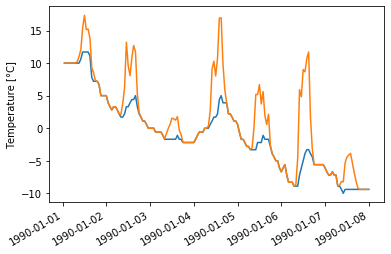

In [13]:
df_tmy['DryBulb'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.ylabel('Temperature [°C]');

Wind speed also has an effect, but it's harder to see in a time series plot like this.  To make it clearer, let's make a scatter plot: 

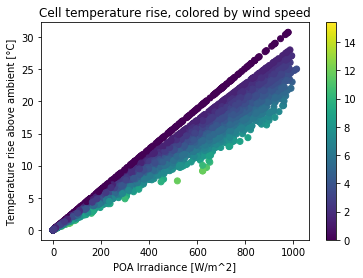

In [23]:
temperature_difference = cell_temperature - df_tmy['DryBulb']
plt.scatter(tracker_poa, temperature_difference, c=df_tmy['Wspd'])
plt.colorbar()
plt.ylabel('Temperature rise above ambient [°C]')
plt.xlabel('POA Irradiance [W/m^2]');
plt.title('Cell temperature rise, colored by wind speed');

The main trend is a bigger temperature difference as incident irradiance increases.  However, this plot shows that higher wind speed reduces the effect -- faster wind means more convective cooling, so a lower cell temperature than it would be in calm air.

Note: the gap at the upper edge of the trend is an artifact of the low resolution of wind speed values in this TMY dataset; there are no values between 0 and 0.3 m/s.

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.